### <center> <b> THE ISSUE </b> </center>
### The issue that stays here is that on switching to $\mathbb{R}^{\text{features}}$ space, the points now hold no correlation to their relative location in the coordinate space in $\mathbb{R}^2$. Hence for the points in the void patch, the corresponding point in fourier feature space is not guaranteed to be between its neighbouring points that were neighbours in the coordinate space

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.image import imsave
from latex import latexify, format_axes
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
    
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


![dog](./dog.jpg)

In [2]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


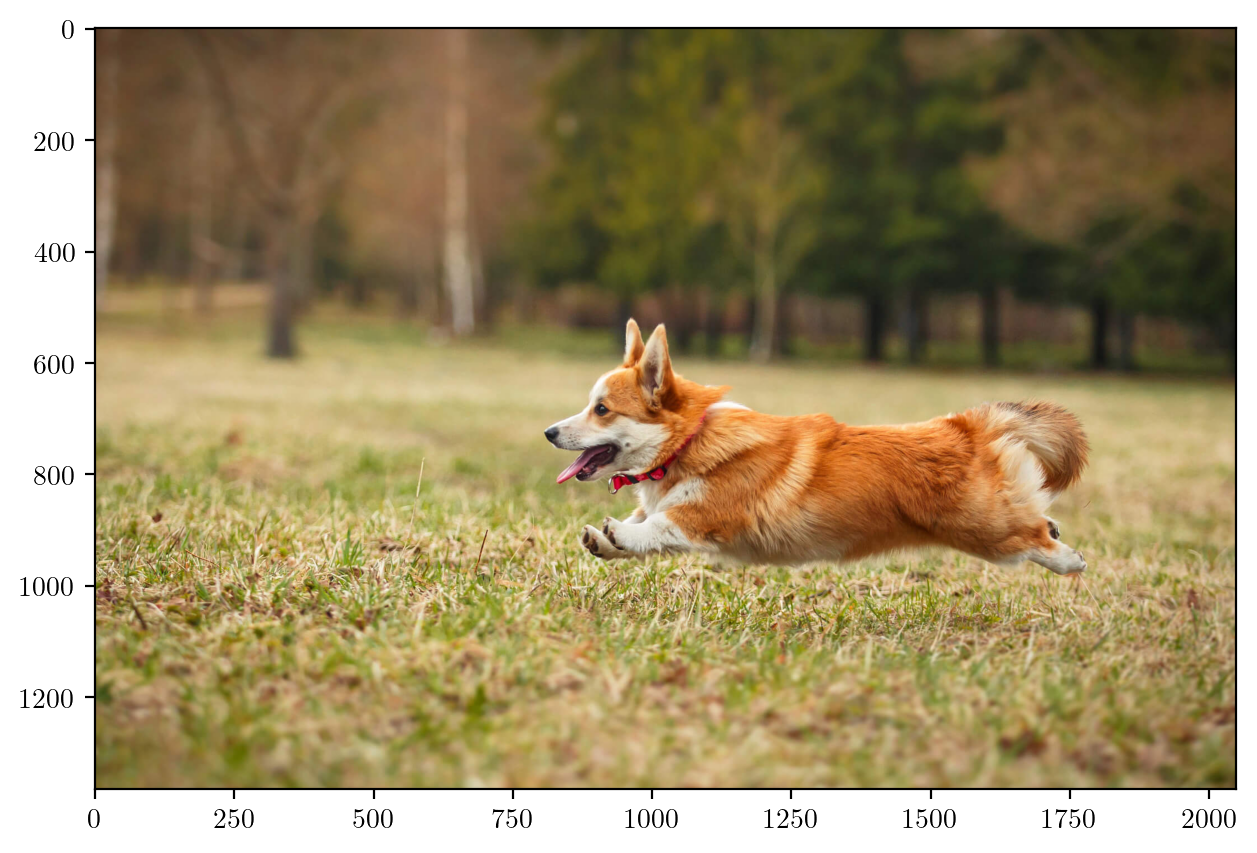

In [3]:
latexify(columns = 2, fig_width = 8)
plt.imshow(rearrange(img, "c h w -> h w c").numpy())
plt.show()

In [4]:
img = torchvision.transforms.functional.crop(img.cpu(), 550, 750, 400, 400)
print(img.shape)

torch.Size([3, 400, 400])


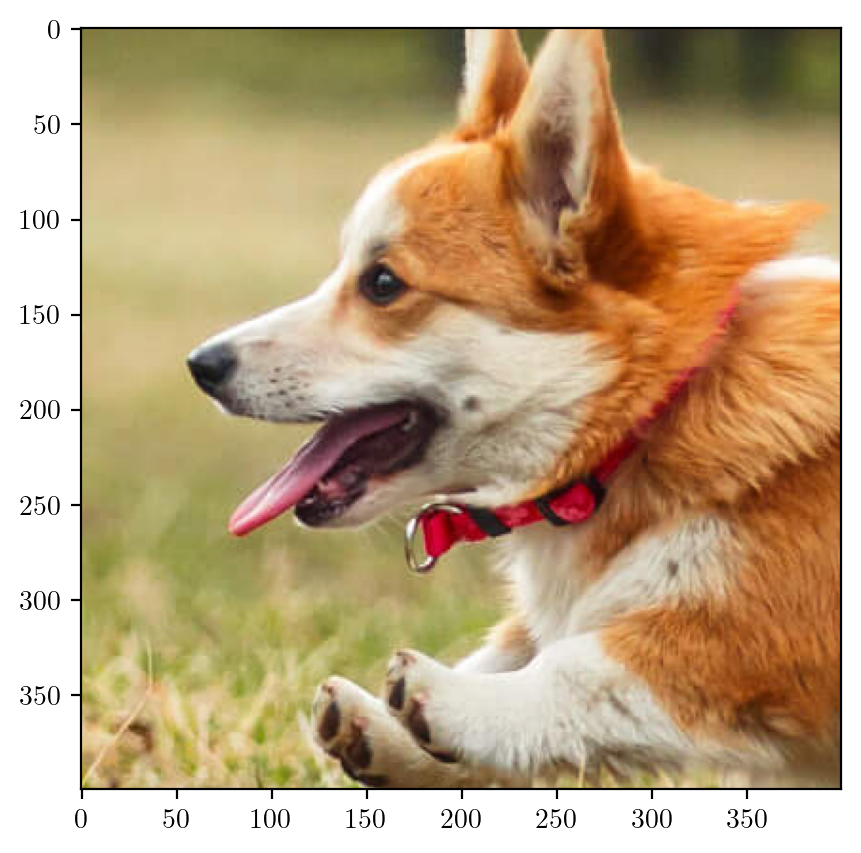

In [5]:
latexify(columns = 2, fig_width = 8)
plt.imshow(rearrange(img, "c h w -> h w c").numpy())
plt.show()

In [6]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device, dtype = torch.float32)
img_scaled

tensor([[[0.4902, 0.4902, 0.5216,  ..., 0.3333, 0.3451, 0.3490],
         [0.4902, 0.4902, 0.5216,  ..., 0.3373, 0.3490, 0.3529],
         [0.5020, 0.5020, 0.5137,  ..., 0.3569, 0.3569, 0.3569],
         ...,
         [0.8667, 0.8118, 0.6039,  ..., 0.4745, 0.4667, 0.4549],
         [0.8275, 0.6588, 0.5647,  ..., 0.4980, 0.4863, 0.4745],
         [0.7294, 0.5569, 0.5725,  ..., 0.5216, 0.5098, 0.4941]],

        [[0.4824, 0.4824, 0.4863,  ..., 0.2980, 0.3098, 0.3137],
         [0.4824, 0.4824, 0.4863,  ..., 0.3020, 0.3137, 0.3176],
         [0.4784, 0.4784, 0.4784,  ..., 0.3255, 0.3255, 0.3255],
         ...,
         [0.7843, 0.7373, 0.5804,  ..., 0.3804, 0.3725, 0.3608],
         [0.7529, 0.5961, 0.5451,  ..., 0.4039, 0.3922, 0.3804],
         [0.6784, 0.5098, 0.5569,  ..., 0.4275, 0.4157, 0.4000]],

        [[0.2510, 0.2510, 0.2549,  ..., 0.1765, 0.1882, 0.1922],
         [0.2510, 0.2510, 0.2549,  ..., 0.1725, 0.1843, 0.1882],
         [0.2431, 0.2431, 0.2471,  ..., 0.1804, 0.1804, 0.

### Function to extract patch $(d \times d)$ from TopLeft corner $(X, Y)$ containing $N$ different colors

In [7]:
def mask_image(img, Corner, d, verbose, display = True):
    X, Y = Corner
    latexify(columns = 2, fig_width = 10)
    img_copy = img.clone()
    img_copy[:, X : X + d, Y : Y + d] = float("nan")
    crop = torchvision.transforms.functional.crop(img.cpu(), X, Y, d, d)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [img.shape[2] / (5 * d), 1]})
    fig.suptitle(fr"{verbose} with corner at $({Corner[0]}, {Corner[1]})$ and patch size = $({d} \times {d})$", fontsize = 16)
    ax[0].imshow(rearrange(img_copy, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title("Masked Image")
    ax[1].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
    ax[1].set_title("Masked Crop")
    if (display):
        plt.show()
    else:
        plt.close()
    return img_copy, crop

#### $$ \text{PSNR} = 20 \log_{10}(\frac{\text{MAX}_I}{\sqrt{\text{MSE}}})$$

In [8]:
def metrics(img1, img2, max_value = 1.0):
    rmse = torch.sqrt(F.mse_loss(img1, img2))
    psnr_value = 20 * torch.log10(max_value / rmse)
    return rmse, psnr_value.item()

### $(30 \times 30)$ frame with **Single Color**

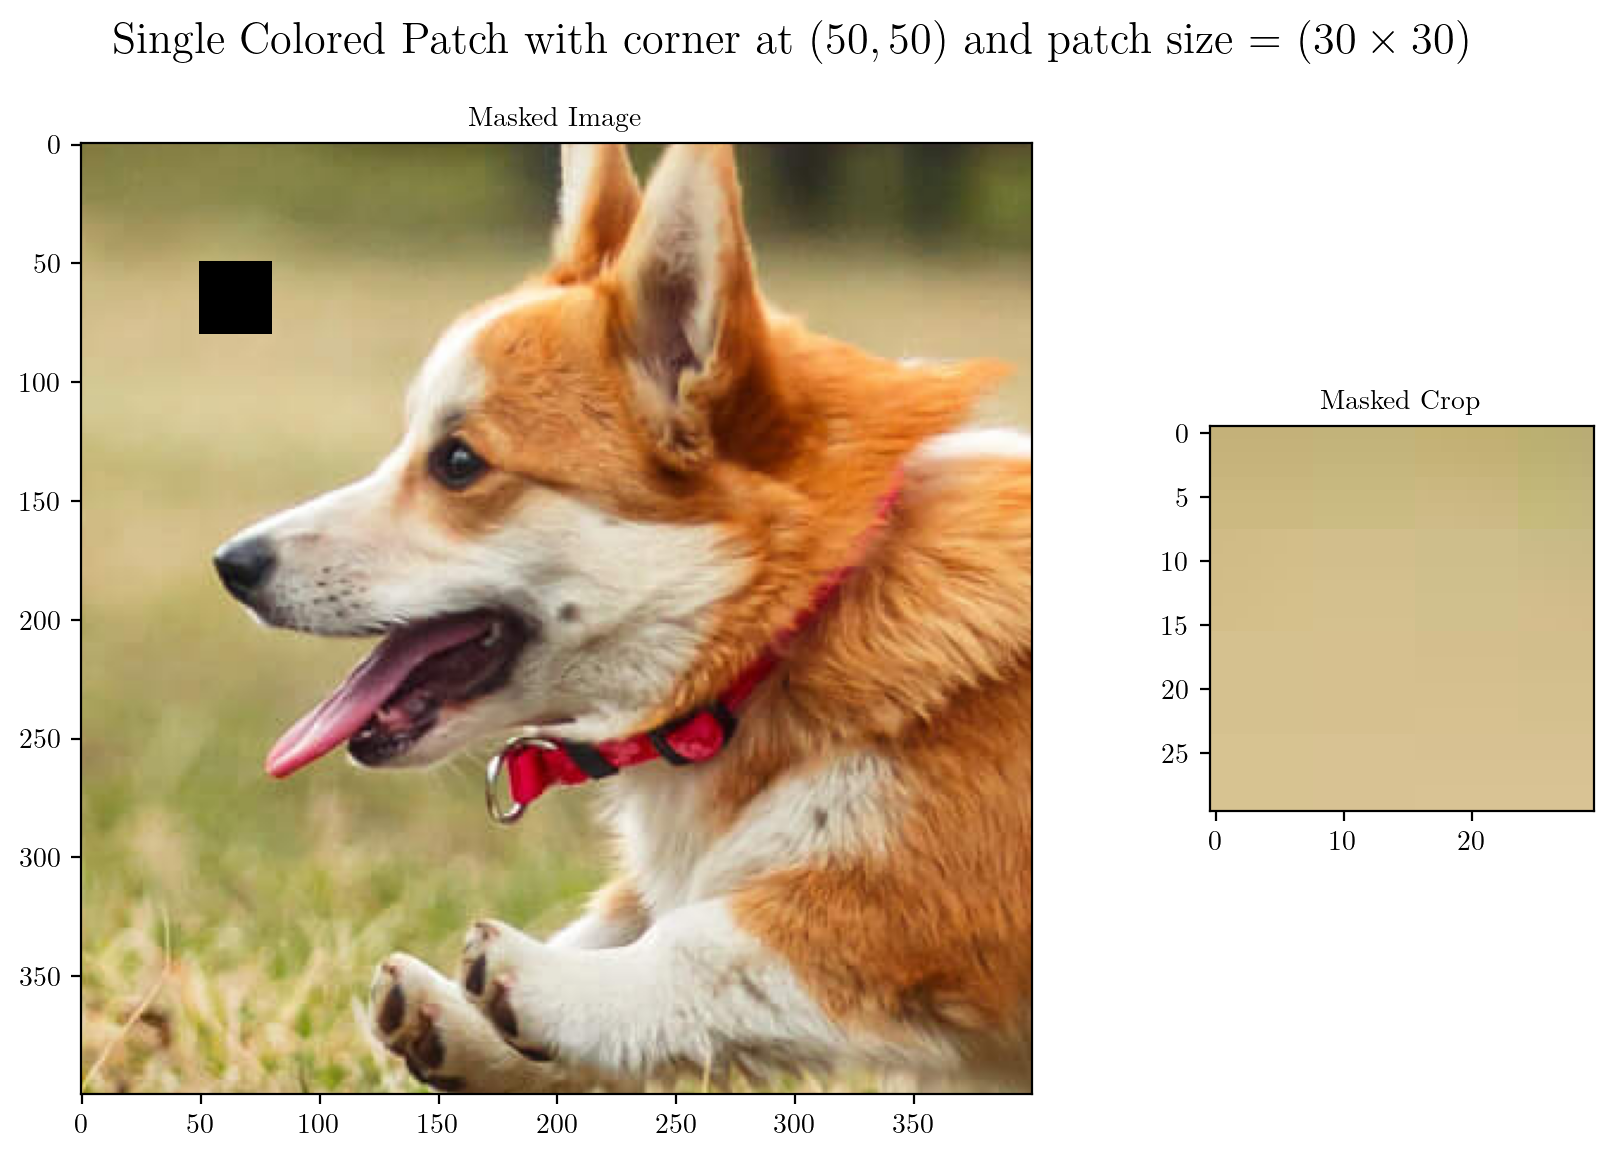

In [9]:
imgSingle30, croppedSingle30 = mask_image(img_scaled, (50, 50), 30, "Single Colored Patch")

## <center> Random Fourier Features </center>

In [10]:
from sklearn.kernel_approximation import RBFSampler

### $$ \text{Cordinate Map}: \mathbb{R}^2 \to \mathbb{R}^3 : [X, Y] \to [R, G, B] $$
### $$ \text{Feature Map}: \mathbb{R}^{\text{features}} \to \mathbb{R}^3 : [X_{1 \cdots k}, Y_{1 \cdots k}] \to [R, G, B] $$
### $$ \text{Final Map}: \mathbb{R}^2 \to \mathbb{R}^{\text{features}} \to \mathbb{R}^3 : [X, Y] \to [X_{1 \cdots k}, Y_{1 \cdots k}] \to [R, G, B] $$

### $$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
### $$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
### Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2)$
### $$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$
###  The Neural Network thus learns the approximation to $\text{Feature Map}$

In [11]:
## RETURN TENSOR ON DEVICE

def create_coordinate_map(img):
    
    """
    img: torch.Tensor of shape [num_channels, height, width]
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    
    
    
    X = torch.stack([h_coords, w_coords], dim = 1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    
    return X, Y

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        # return torch.sigmoid(self.linear(x))
        return self.linear(x)

#### $\text{Original Image} \to (W \times H)$ and our cropped image has a patch of $(d \times d)$ removed, hence we have access to only $wh - d^2$ points' ($ \in \mathbb{R}^{\text{features}}$) RGB ($\in \mathbb{R}^3$) values as opposed to entire feature space's grid points $wh$, so we only learn/train the neural network on these reduced number of points $wh - d^2$ and predct on the entire feature space grid of $wh$ points. It is expected that the NN would be able to produce the RGB $\in \mathbb{R}^3$ of the missed out $d^2$ points.

In [13]:
def train(net, lr, X, Y, epochs, convergence, verbose= True):
    
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, features) -> Feature Space Grid
    Y: torch.Tensor of shape (num_samples, 3) -> RGB Values
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    prev_loss = float('inf')
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        if torch.abs(prev_loss - loss) < convergence:
            print(loss.item())
            break
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss.item():.6f}")
        
        prev_loss = loss.item()
    print(loss.item())

In [14]:
def predict_plot(original_img, cropped_img, net, X):
    
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, features)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    
    
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    
    rmse, psnr = metrics(original_img, rearrange(outputs, "h w c -> c h w"))
    
    latexify(columns = 2)
    fig, ax = plt.subplots(nrows = 1, ncols = 3, gridspec_kw = {"width_ratios": [1, 1, 1]}, figsize = (13, 6))
    fig.suptitle("Reconstruction using RFF" "\n" f"RMSE : {rmse} | PSNR : {psnr}", fontsize = 12)                                                  
    ax[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title("Ground Truth Image")
    ax[0].axis("off")
    ax[1].imshow(rearrange(cropped_img, 'c h w -> h w c').cpu().detach().numpy())
    ax[1].set_title("Cropped Image")
    ax[1].axis("off")
    ax[2].imshow(outputs.cpu())
    ax[2].set_title("Reconstructed Image")
    ax[2].axis("off")
    plt.show()

In [15]:
## RETURN TENSOR ON DEVICE

def create_rff_features(X, num_features, sigma, device):
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32).to(device)

In [16]:
torch.cuda.empty_cache()

### Create Coordinate Map out of Cropped Image $(W \times H) - (d \times d)$
### $ \text{Map} : \mathbb{R}^2 \to \mathbb{R}^3 \implies [X, Y] \to [R, G, B]$

In [17]:
dog_X, dog_Y = create_coordinate_map(imgSingle30)
print(dog_X.shape, dog_Y.shape)

torch.Size([160000, 2]) torch.Size([160000, 3])


### Scale the $(X, Y)$ Features using MinMaxScaler

In [18]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
## Now we may delete dog_X from GPU and clear GPU cache
del dog_X
torch.cuda.empty_cache()
## First 10 entries of Scaled (X, Y)
print(dog_X_scaled.shape)
print(dog_X_scaled[:10, :])

torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        [-1.0000, -0.9850],
        [-1.0000, -0.9799],
        [-1.0000, -0.9749],
        [-1.0000, -0.9699],
        [-1.0000, -0.9649],
        [-1.0000, -0.9599],
        [-1.0000, -0.9549]], device='cuda:0')


### Create RFF Features out of Scaled $[X, Y]$

In [19]:
features = 17000
mask = rearrange(~torch.isnan(imgSingle30)[0], "h w -> (h w)").to(device)
X_rff = create_rff_features(dog_X_scaled, features, 0.008, device)
del dog_X_scaled
torch.cuda.empty_cache()
print("Entire Coordinate Map in the Feature Space")
print(X_rff)
print(X_rff.shape)
print("Only the known RBG valued Coordinate Map in Feature Space")
print(X_rff[mask])
print(X_rff[mask].shape)
print("The unknown RBG valued Coordinate Map in Feature Space")
print(X_rff[~mask])
print(X_rff[~mask].shape)

Entire Coordinate Map in the Feature Space
tensor([[ 1.0359e-02,  1.0741e-02, -1.0313e-02,  ...,  1.0833e-02,
          1.9495e-03, -3.9813e-03],
        [ 9.4452e-03,  1.0499e-02, -4.2609e-03,  ...,  1.0112e-02,
         -5.5529e-04, -7.7875e-03],
        [ 8.1050e-03,  1.0121e-02,  4.7010e-03,  ...,  7.6372e-03,
         -3.0305e-03, -1.0208e-02],
        ...,
        [-8.4661e-04, -1.2614e-03,  6.1941e-03,  ...,  2.0993e-05,
          1.2655e-03,  8.7819e-03],
        [ 1.4576e-03, -2.6494e-05, -2.6223e-03,  ...,  4.4380e-03,
          3.7079e-03,  1.0626e-02],
        [ 3.6959e-03,  1.2088e-03, -9.6476e-03,  ...,  8.0850e-03,
          5.9516e-03,  1.0578e-02]], device='cuda:0')
torch.Size([160000, 17000])
Only the known RBG valued Coordinate Map in Feature Space
tensor([[ 1.0359e-02,  1.0741e-02, -1.0313e-02,  ...,  1.0833e-02,
          1.9495e-03, -3.9813e-03],
        [ 9.4452e-03,  1.0499e-02, -4.2609e-03,  ...,  1.0112e-02,
         -5.5529e-04, -7.7875e-03],
        [ 8.1050

### Training the Linear Model on the known RBG valued Coordinate Map in Feature Space

In [20]:
net = LinearModel(features, 3)
net.to(device)
mask = rearrange(~torch.isnan(imgSingle30)[0], "h w -> (h w)").to(device)
train(net, 0.01, X_rff[mask], dog_Y[mask], 2000, convergence = 1e-6)
del dog_Y
torch.cuda.empty_cache()

Epoch: 0 | Loss: 0.353229
Epoch: 100 | Loss: 0.012529
Epoch: 200 | Loss: 0.006079
Epoch: 300 | Loss: 0.003620
Epoch: 400 | Loss: 0.002367
Epoch: 500 | Loss: 0.001658
Epoch: 600 | Loss: 0.001239
Epoch: 700 | Loss: 0.000988
Epoch: 800 | Loss: 0.000839
0.0008134769159369171
0.0008134769159369171


### NN trained and only it remains on the GPU, rest tensors have been cleared off

### Predicting on Entire Coordinate Map in the Feature Space

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


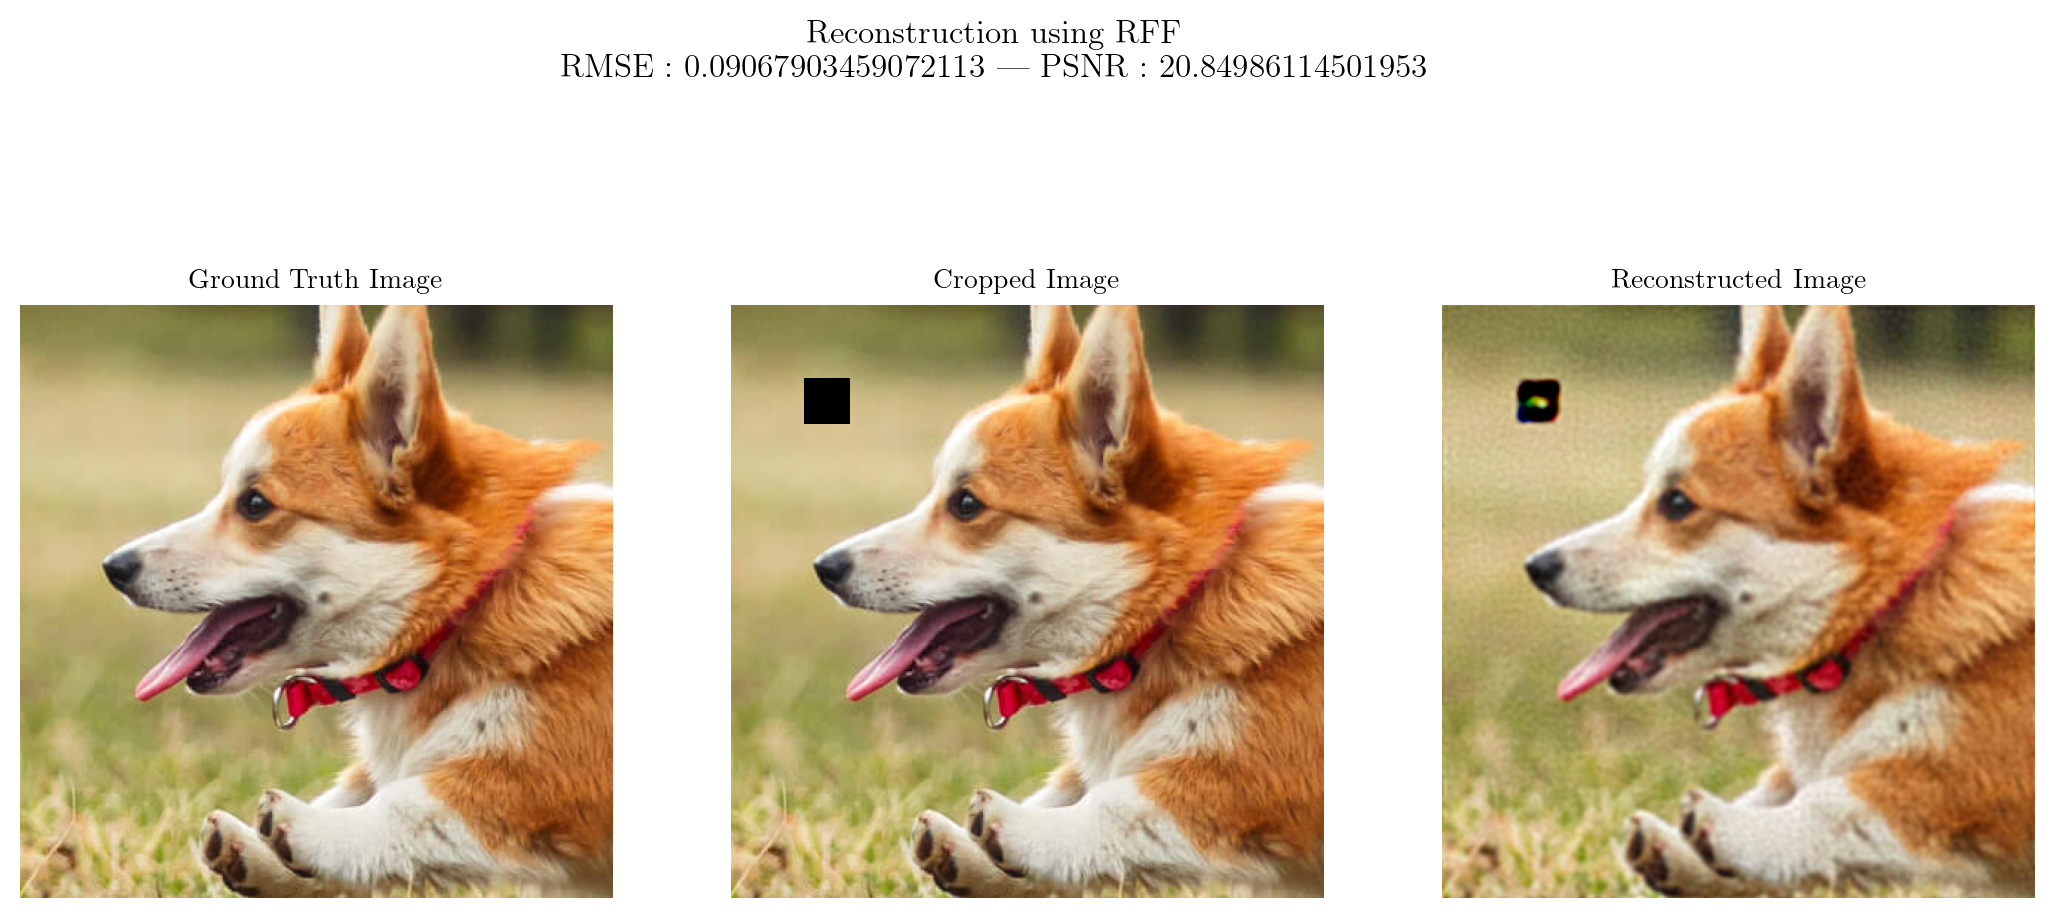

In [21]:
predict_plot(img_scaled, imgSingle30, net, X_rff)

In [24]:
# import gc
# del X_rff
# gc.collect()